# Adaptive Line Enhancer for speech denoising

This notebook does the following:
1. Load speech and noise files, create additive mixture
2. Choose a learning parameter mu, delta time units which is the range of correlation that is used for statistical prediction

In [1]:
import numpy as np
import sys
import os
import matplotlib.pylab as plt

import padasip as pa
from IPython.display import Audio

sys.path.append(os.getcwd())
from ale_anc import ale_anc

In [2]:
""" Generate the noisy speech signal from a clean speech signal by adding noise"""
import librosa 

speech_file = "dataset/speech/female.wav"
noise_file = "dataset/noise/noise_white.wav"

s, fs = librosa.load(speech_file, sr=16000)
s = np.concatenate((s, s))

n, fs_noise = librosa.load(noise_file, sr=16000)

noise_gain = 0.7
n = noise_gain * n[:len(s)]

x = s + n

# Compute the Input SNR for signal s to noise n
x_snr = 10*np.log10(np.sum(s**2)/np.sum(n**2))
print("SNR: {:.2f}dB".format(x_snr))

SNR: 18.30dB


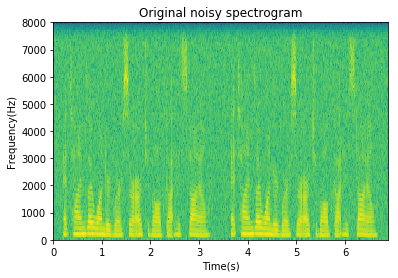

In [3]:
plt.specgram(x, Fs=fs);
plt.title('Original noisy spectrogram');
plt.xlabel('Time(s)');
plt.ylabel('Frequency(Hz)');

(110306,) (110306, 128)


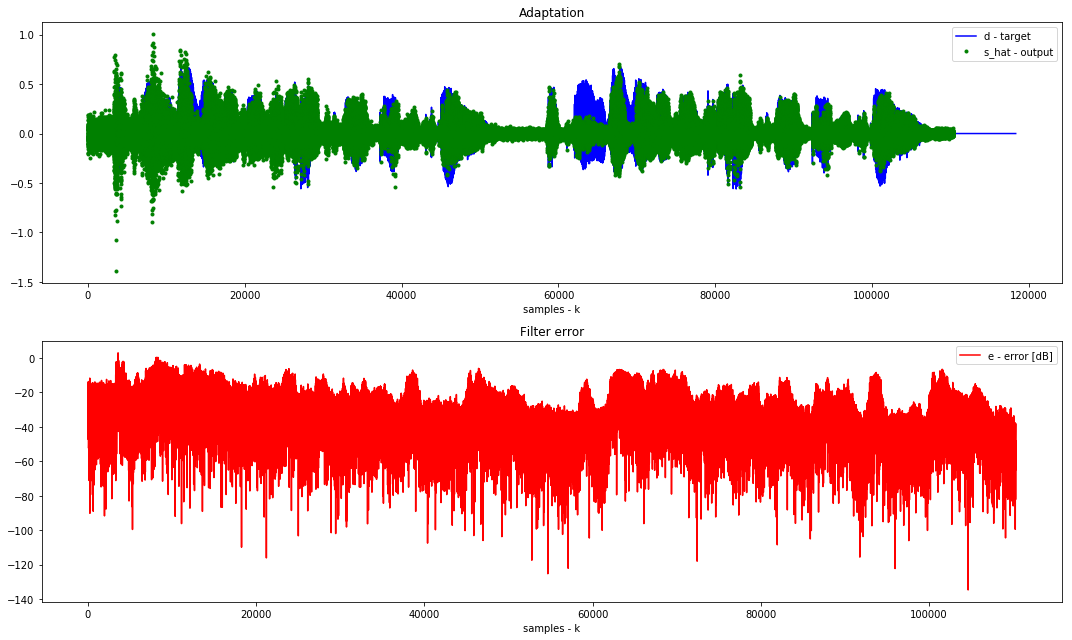

In [6]:
# creation of data
N = 128
delta_ms = 32
delta = int(fs*delta_ms/1000)

s_hat, n_hat, weights, d = ale_anc(x, fs, N, delta, scheme=3)

# show results
plt.figure(figsize=(15,9))
plt.subplot(211);plt.title("Adaptation");plt.xlabel("samples - k")
plt.plot(d,"b", label="d - target")
plt.plot(s_hat,"g.", label="s_hat - output");plt.legend()
plt.subplot(212);plt.title("Filter error");plt.xlabel("samples - k")
plt.plot(10*np.log10(n_hat**2),"r", label="e - error [dB]");plt.legend()
plt.tight_layout()
plt.show()

In [7]:
# Create s_hat2 which is the original speech signal passed through the delay and ALE to see how much distortion there is to the original speech
s_hat2 = []
s_ale = pa.input_from_history(np.concatenate((np.zeros(delta,), s)), N)
for i in range(weights.shape[0]):
    val = np.dot(weights[i], s_ale[i])
    s_hat2.append(val)
s_hat2 = np.array(s_hat2)
n_hat2 = []
n_ale = pa.input_from_history(np.concatenate((np.zeros(delta,), n)), N)
for i in range(weights.shape[0]):
    val = np.dot(weights[i], n_ale[i])
    n_hat2.append(val)  
n_hat2 = np.array(n_hat2)

/Users/abhipray/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:7609: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


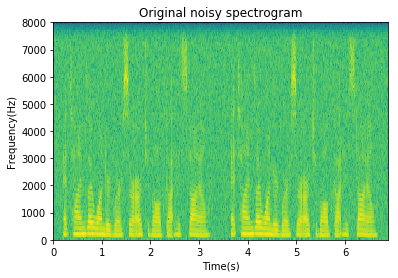

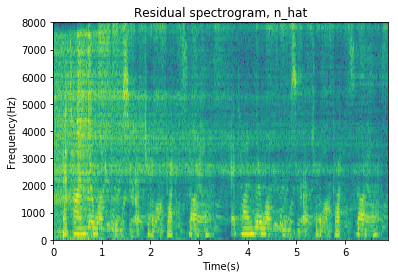

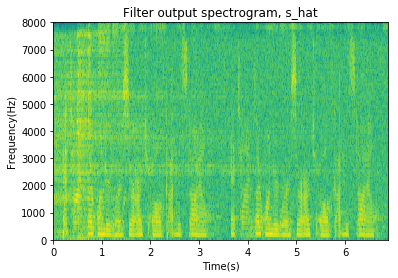

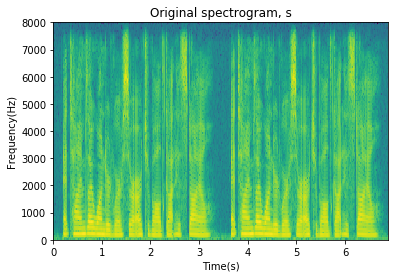

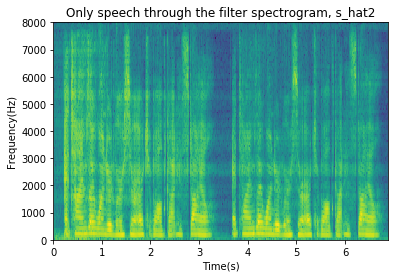

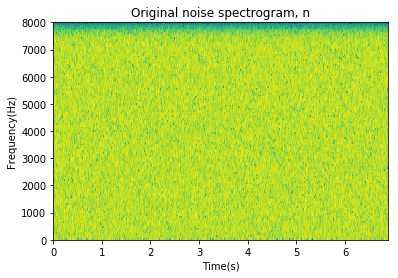

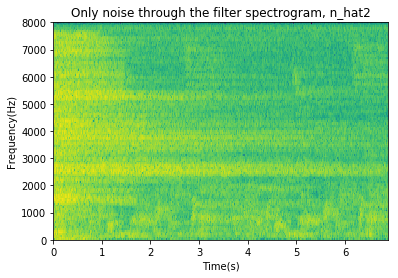

In [8]:
plt.specgram(x, Fs=fs);
plt.title('Original noisy spectrogram');
plt.xlabel('Time(s)');
plt.ylabel('Frequency(Hz)');
plt.figure();
plt.specgram(n_hat, Fs=fs);
plt.title('Residual spectrogram, n_hat');
plt.xlabel('Time(s)');
plt.ylabel('Frequency(Hz)');
plt.figure();
plt.specgram(s_hat, Fs=fs);
plt.title('Filter output spectrogram, s_hat');
plt.xlabel('Time(s)');
plt.ylabel('Frequency(Hz)');
plt.figure();
plt.specgram(s, Fs=fs);
plt.title('Original spectrogram, s');
plt.xlabel('Time(s)');
plt.ylabel('Frequency(Hz)');
plt.figure();
plt.specgram(s_hat2, Fs=fs);
plt.title('Only speech through the filter spectrogram, s_hat2');
plt.xlabel('Time(s)');
plt.ylabel('Frequency(Hz)');
plt.figure();
plt.specgram(n, Fs=fs);
plt.title('Original noise spectrogram, n');
plt.xlabel('Time(s)');
plt.ylabel('Frequency(Hz)');
plt.figure();
plt.specgram(n_hat2, Fs=fs);
plt.title('Only noise through the filter spectrogram, n_hat2');
plt.xlabel('Time(s)');
plt.ylabel('Frequency(Hz)');

In [9]:
Audio(data=x, rate=fs)

In [10]:
Audio(data=n_hat, rate=fs)

In [11]:
Audio(data=s_hat, rate=fs)

In [12]:
Audio(data=s_hat2, rate=fs)

In [13]:
Audio(data=s, rate=fs)

# Metrics

1. Input SNR
2. Output SNR
3. Input Distortion

In [14]:
# Input SNR

input_snr = 10*np.log10(np.sum(s**2)/np.sum(n**2))
print("Input SNR: {} dB".format(input_snr))

Input SNR: 18.300803899765015 dB


In [15]:
# Output SNR
# Use the last 10% of the audio clip
samp_idx = int(0.1*len(s_hat2));
output_snr = np.sum(s_hat2[samp_idx:]**2)/np.sum(n_hat2[samp_idx:]**2)
print("Output SNR: {} dB".format(output_snr))

Output SNR: 131.4407775064004 dB


In [16]:
# Speech distortion
mse = 10*np.log10(np.sum((s - s_hat2[:len(s)])**2)/len(s))
print("MSE: {} dB".format(mse))

MSE: -13.705802334250794 dB


In [17]:
len(s_hat2), len(s)

(110306, 110242)

In [18]:
delta

512

Publish results on six speech files, 3 different schemes, 3 different noises

- I/O SNR
- Itakura-Saito distance between s and s_hat